In [45]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import os
import ee
import numpy as np
from geeml.extract import extractor
import pandas as pd
import random
# import geemap
# Authenticate GEE
# ee.Authenticate()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/explore/nobackup/people/spotter5/cnn_mapping/gee-serdp-upload-7cd81da3dc69.json"

service_account = 'gee-serdp-upload@appspot.gserviceaccount.com'
credentials = ee.ServiceAccountCredentials(service_account, "/explore/nobackup/people/spotter5/cnn_mapping/gee-serdp-upload-7cd81da3dc69.json")
ee.Initialize(credentials)
# Initialize GEE with high-volume end-point
# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
ee.Initialize()


# In[2]:


import geemap
import os
from google.cloud import storage
from google.cloud import client


# In[3]:


os.environ["GCLOUD_PROJECT"] = "gee-serdp-upload"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/explore/nobackup/people/spotter5/cnn_mapping/gee-serdp-upload-7cd81da3dc69.json"
storage_client = storage.Client.from_service_account_json("/explore/nobackup/people/spotter5/cnn_mapping/gee-serdp-upload-7cd81da3dc69.json")

os.environ["GCLOUD_PROJECT"] = "gee-serdp-upload"
storage_client = storage.Client()
# bucket_name = 'smp-scratch/mtbs_1985'
bucket_name = 'smp-scratch'

bucket = storage_client.bucket(bucket_name)


# Import assetts of interest

# In[4]:


geometry = ee.FeatureCollection('users/spotter/fire_cnn/raw/eurasia') #area of interest
mod1 = ee.ImageCollection("MODIS/061/MOD10A1") #active fire
mod2 = ee.ImageCollection("MODIS/061/MYD10A1") #active fire
fire_cci = ee.ImageCollection("ESA/CCI/FireCCI/5_1") #active fire
mod_burn = ee.ImageCollection("MODIS/061/MCD64A1") #mcd64a1
snow = ee.ImageCollection('MODIS/006/MOD10A1') #modis snow cover
# Load the MODIS water mask image and invert it.
water_mask = ee.Image('MODIS/MOD44W/MOD44W_005_2000_02_24').select('water_mask').Not()


sent_2A = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") #sentinel 2
s2Clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') #cloud masking for sentinel
# s2Clouds = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY') #cloud masking for sentinel
# lfdb = ee.FeatureCollection("users/spotter/fire_cnn/raw/nbac_1985") #nbac_fire_polygons, this can be any polygon shapefile, final version would be nbac and mtbs
# lfdb = ee.FeatureCollection("users/spotter/fire_cnn/ann_w_id") #anna polygons 
lfdb = ee.FeatureCollection("users/spotter/fire_cnn/anna_w_id_sampled") #anna polygons 

# input_grid = ee.FeatureCollection('users/spotter/fire_cnn/raw/eurasia_dnbr_grid_clip') #grid to loop through to get around memory errors


# Cloud masking Sentinel 2

# In[5]:


#probability of clouds
MAX_CLOUD_PROBABILITY = 50

def sent_maskcloud(image):


    image = image.select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'], ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'])# rename bands to match landsat

    image =  image.toShort()

    clouds = ee.Image(image.get('cloud_mask')).select('probability')

    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)

    image = image.updateMask(isNotCloud)

    #reproject 30m but remember b1, b2 and b3 are 10 and the rest are 20
    image1 = image.select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4'])
    image2 = image.select(['SR_B5', 'SR_B7'])


    image1 = image1.reproject(
    crs = image1.projection().crs(),
    scale = 30) #resample for landsat


    image2 = image2.reproject(
    crs = image2.projection().crs(),
    scale = 30) #resample for landsat

    image = image1.addBands(image2)

    return image

#Join S2 SR with cloud probability dataset to add cloud mask.
s2SrWithCloudMask = ee.Join.saveFirst('cloud_mask').apply(

  primary=sent_2A,
  secondary=s2Clouds,
  condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

#apply cloud masking
sent_2A = ee.ImageCollection(s2SrWithCloudMask).map(sent_maskcloud)


# Correct landsat scale factor and sentinel scale factor

# In[6]:


def mask(image):
    qa = image.select('QA_PIXEL')
    mask = qa.bitwiseAnd(8).eq(0).And(qa.bitwiseAnd(10).eq(0)).And(qa.bitwiseAnd(32).eq(0))
    return(image.updateMask(mask))

def land_scale(image):

    return(image.multiply(0.0000275).add(-0.2))

def sent_scale(image):
    return(image.multiply(0.0001))


# Logan Coefficients to apply

# In[7]:


import pandas as pd
coeffs = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/raw_files/boreal_xcal_regression_coefficients.csv").fillna(0)
#l5
def landsat_correct(sat, bands):

    """argument 1 is which sattelite, LANDASAT_5 or LANDSAT_8
    argument 2 is bands of interest.  Bands must be in same order as EE,
    
    regression is of form,
    L7 = B0 + (B1 * L5/8) + (B2 * L^2) + (B3 * L^3)
    """

    #bands of interest in order of interest
    l5 = coeffs[(coeffs['satellite'] == sat) & (coeffs['band.or.si'] .isin (bands))] 

    #arrange the band or si column
    l5['band.or.si']=pd.Categorical(l5['band.or.si'],categories=bands)
    l5=l5.sort_values('band.or.si')

    b0 = l5['B0'].values.tolist()
    b1 = l5['B1'].values.tolist()
    b2 = l5['B2'].values.tolist()
    b3 = l5['B3'].values.tolist()

    return (b0, b1, b2, b3)

#get the corrections, each output is a list at one of the four locations
l8_corr = landsat_correct(sat = 'LANDSAT_8', bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'nbr', 'ndvi', 'ndii'])
l5_corr = landsat_correct(sat = 'LANDSAT_5', bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'nbr', 'ndvi', 'ndii'])




# I might need to convert to float

# In[8]:


def to_float(image):

    b1 = image.select('SR_B1').cast({'SR_B1':'float'}) #0
    b2 = image.select('SR_B2').cast({'SR_B2':'float'}) #1
    b3 = image.select('SR_B3').cast({'SR_B3':'float'}) #2
    b4 = image.select('SR_B4').cast({'SR_B4':'float'}) #3
    b5 = image.select('SR_B5').cast({'SR_B5':'float'}) #4
    b6 = image.select('SR_B7').cast({'SR_B7':'float'}) #5

    image = b1.addBands(b2).addBands(b3).addBands(b4).addBands(b5).addBands(b6)

    return image

def filter_cl(image):
    cl = image.select('ConfidenceLevel')
    image = image.updateMask(cl.gte(50)).select('BurnDate')
    return image

def mod_act_map(image):
    image = image.addBands(ee.Image(ee.Date(image.get('system:time_start')).getRelative('day','year').add(1)).clamp(1,366)).updateMask(image.select('FireMask').gte(7))
    return image.updateMask(image.select('constant').gt(60));


# In[9]:


os.environ["GCLOUD_PROJECT"] = "gee-serdp-upload"

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/explore/nobackup/people/spotter5/cnn_mapping/gee-serdp-upload-7cd81da3dc69.json"
storage_client = storage.Client.from_service_account_json("/explore/nobackup/people/spotter5/cnn_mapping/gee-serdp-upload-7cd81da3dc69.json")

os.environ["GCLOUD_PROJECT"] = "gee-serdp-upload"
storage_client = storage.Client()
# bucket_name = 'smp-scratch/mtbs_1985'
bucket_name = 'smp-scratch'

bucket = storage_client.bucket(bucket_name)


# Function to return the pre_fire and post_fire landsat and sentinel 2 data

# In[10]:


def get_pre_post(pre_start, pre_end, post_start, post_end, geometry):

    """parameters are:
    pre_start: the start date for pre fire imagery
    pre_end: the end date for pre fire imagery
    post_start: the start date for post fire imagery
    post_end: the end date for post_fire imagery
    geometry: the geometry to filter by
    """

    #landsat 5
    lt5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2').filterDate(pre_start, post_end).filterBounds(geometry)
    #landsat 7
    le7 = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterDate(pre_start, post_end).filterBounds(geometry)
    #landsat 8
    lc8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate(pre_start, post_end).filterBounds(geometry)
    #sentinel 2
    sent = sent_2A.filterDate(pre_start, post_end).filterBounds(geometry)

    #select bands
    pre_lt5 = lt5.filterDate(pre_start, pre_end).map(mask).map(land_scale).select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']).map(to_float)

    #       #ensure we have imagery for the sensor
    if pre_lt5.size().getInfo() > 0 :


        #take the median
        pre_lt5 = pre_lt5.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        pre_lt5_nbr = pre_lt5.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        pre_lt5_ndvi = pre_lt5.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        pre_lt5_ndii = pre_lt5.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        pre_lt5 = pre_lt5.addBands(pre_lt5_nbr).addBands(pre_lt5_ndvi).addBands(pre_lt5_ndii)

        #apply the corrections

        l5_pre_corr = pre_lt5.multiply(l5_corr[1]).add(pre_lt5.pow(2).multiply(l5_corr[2])).add(pre_lt5.pow(3).multiply(l5_corr[3])).add(l5_corr[0])

    #-------now do post-fire
    #select bands
    post_lt5 = lt5.filterDate(post_start, post_end).map(mask).map(land_scale).select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']).map(to_float)

    #       #ensure we have imagery for the sensor
    if post_lt5.size().getInfo() > 0 :



        #take the median
        post_lt5 = post_lt5.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        post_lt5_nbr = post_lt5.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        post_lt5_ndvi = post_lt5.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        post_lt5_ndii = post_lt5.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        post_lt5 = post_lt5.addBands(post_lt5_nbr).addBands(post_lt5_ndvi).addBands(post_lt5_ndii)

        #apply the corrections

        l5_post_corr = post_lt5.multiply(l5_corr[1]).add(post_lt5.pow(2).multiply(l5_corr[2])).add(post_lt5.pow(3).multiply(l5_corr[3])).add(l5_corr[0])


      #         #------------------------------------------Landsat 7, no corrections but get things clipped and do pre fire/post_fire stuff


    #select bands
    pre_le7 = le7.filterDate(pre_start, pre_end).map(mask).map(land_scale).select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']).map(to_float)

    #       #ensure we have imagery for the sensor
    if pre_le7.size().getInfo() > 0 :



        #take the median
        pre_le7 = pre_le7.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        pre_le7_nbr = pre_le7.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        pre_le7_ndvi = pre_le7.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        pre_le7_ndii = pre_le7.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        pre_le72 = pre_le7.addBands(pre_le7_nbr).addBands(pre_le7_ndvi).addBands(pre_le7_ndii)

    #-------now do post-fire
    #select bands
    post_le7 = le7.filterDate(post_start, post_end).map(mask).map(land_scale).select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']).map(to_float)
    #       #ensure we have imagery for the sensor
    if post_le7.size().getInfo() > 0 :


        #take the median
        post_le7 = post_le7.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        post_le7_nbr = post_le7.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        post_le7_ndvi = post_le7.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        post_le7_ndii = post_le7.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        post_le72 = post_le7.addBands(post_le7_nbr).addBands(post_le7_ndvi).addBands(post_le7_ndii)

    #------------------------------------------Landsat 8 corrections


    #-------first do pre-fire

    #select bands
    pre_lc8 = lc8.filterDate(pre_start, pre_end).map(mask).map(land_scale).select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'],['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']) .map(to_float)

    #       #ensure we have imagery for the sensor
    if pre_lc8.size().getInfo() > 0 :



        #take the median
        pre_lc8 = pre_lc8.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        pre_lc8_nbr = pre_lc8.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        pre_lc8_ndvi = pre_lc8.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        pre_lc8_ndii = pre_lc8.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        pre_lc8 = pre_lc8.addBands(pre_lc8_nbr).addBands(pre_lc8_ndvi).addBands(pre_lc8_ndii)

        #apply the corrections

        l8_pre_corr = pre_lc8.multiply(l8_corr[1]).add(pre_lc8.pow(2).multiply(l8_corr[2])).add(pre_lc8.pow(3).multiply(l8_corr[3])).add(l8_corr[0])

    #-------now do post-fire
    #select bands
    post_lc8 = lc8.filterDate(post_start, post_end).map(mask).map(land_scale).select(['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7'],['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']) .map(to_float)

    #       #ensure we have imagery for the sensor
    if post_lc8.size().getInfo() > 0 :



        #take the median
        post_lc8 = post_lc8.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        post_lc8_nbr = post_lc8.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        post_lc8_ndvi = post_lc8.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        post_lc8_ndii = post_lc8.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        post_lc8 = post_lc8.addBands(post_lc8_nbr).addBands(post_lc8_ndvi).addBands(post_lc8_ndii)

        #apply the corrections

        l8_post_corr = post_lc8.multiply(l8_corr[1]).add(post_lc8.pow(2).multiply(l8_corr[2])).add(post_lc8.pow(3).multiply(l8_corr[3])).add(l8_corr[0])

        # #          #------------------------------------------Sentinel 2 corrections, use landsat 8 coefficients


    ##-------first do pre-fire

    #select bands
    pre_sent = sent_2A.filterDate(pre_start, pre_end).map(sent_scale).select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']).map(to_float)

    #       #ensure we have imagery for the sensor
    if pre_sent.size().getInfo() > 0 :



          #take the median
        pre_sent = pre_sent.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        pre_sent_nbr = pre_sent.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        pre_sent_ndvi = pre_sent.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        pre_sent_ndii = pre_sent.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        pre_sent = pre_sent.addBands(pre_sent_nbr).addBands(pre_sent_ndvi).addBands(pre_sent_ndii)

        #apply the corrections

        sent_pre_corr = pre_sent.multiply(l8_corr[1]).add(pre_sent.pow(2).multiply(l8_corr[2])).add(pre_sent.pow(3).multiply(l8_corr[3])).add(l8_corr[0])

    #-------now do post-fire
    #select bands
    post_sent = sent_2A.filterDate(post_start, post_end).map(sent_scale).select(['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']).map(to_float)

    #       #ensure we have imagery for the sensor
    if post_sent.size().getInfo() > 0 :



        #take the median
        post_sent = post_sent.median().clip(geometry)

        #calculate nbr, ndvi and ndii
        post_sent_nbr = post_sent.normalizedDifference(['SR_B4', 'SR_B7']).select([0], ['NBR']).cast({'NBR': 'float'})
        post_sent_ndvi = post_sent.normalizedDifference(['SR_B4', 'SR_B3']).select([0], ['NDVI']).cast({'NDVI': 'float'})
        post_sent_ndii = post_sent.normalizedDifference(['SR_B4', 'SR_B5']).select([0], ['NDII']).cast({'NDII': 'float'})

        #add the bands back
        post_sent = post_sent.addBands(post_sent_nbr).addBands(post_sent_ndvi).addBands(post_sent_ndii)

        #apply the corrections

        sent_post_corr = post_sent.multiply(l8_corr[1]).add(post_sent.pow(2).multiply(l8_corr[2])).add(post_sent.pow(3).multiply(l8_corr[3])).add(l8_corr[0])


    #try to see if image exists, if so append

    #----------------------all prefire

    #       #empty list for pre-fire, use this to combine if we have land 5, 7, 8 or sentinel
    pre_input = []

    try:
        l5_pre_corr.getInfo()
        pre_input.append(l5_pre_corr)

    except:
        pass

    try:
        pre_le72.getInfo()
        pre_input.append(pre_le72)

    except:
        pass

    try:
        l8_pre_corr.getInfo()
        pre_input.append(l8_pre_corr)

    except:
        pass

    try:
        sent_pre_corr.getInfo()
        pre_input.append(sent_pre_corr)

    except:
        pass


    #----------------------all postfire

    #         #       #empty list for post-fire, use this to combine if we have land 5, 7, 8 or sentinel
    post_input = []

    try:
        l5_post_corr.getInfo()
        post_input.append(l5_post_corr)

    except:
        pass

    try:
        post_le72.getInfo()
        post_input.append(post_le72)

    except:
        pass

    try:
        l8_post_corr.getInfo()
        post_input.append(l8_post_corr)

    except:
        pass

    try:
        sent_post_corr.getInfo()
        post_input.append(sent_post_corr)

    except:
        pass

    #return the two lists of pre input and post input
    return pre_input, post_input



# In[11]:


#masking snow cover functions
#reference https://developers.google.com/earth-engine/tutorials/community/identifying-first-day-no-snow
def mask_snow(img):
    return img.gte(10)

def add_date_bands(img):
    global start_date, start_year_var
    date = img.date()
    cal_doy = date.getRelative('day', 'year')
    rel_doy = date.difference(start_date, 'day')
    millis = date.millis()
    date_bands = ee.Image.constant([cal_doy, rel_doy, millis, start_year_var]).rename(['calDoy', 'relDoy', 'millis', 'year'])
    return img.addBands(date_bands).cast({'calDoy': 'int', 'relDoy': 'int', 'millis': 'long', 'year': 'int'}).set('millis', millis)


# def process_year(year):
#     global start_doy, start_date, start_year_var
#     start_year_var = year
#     first_doy = ee.Date.fromYMD(year, 1, 1)
#     start_date = first_doy.advance(start_doy - 1, 'day')
#     end_date = start_date.advance(1, 'year').advance(1, 'day')
#     year_col = snow.filterDate(start_date, end_date)
#     # no_snow_img = year_col.map(add_date_bands).sort('millis').reduce(ee.Reducer.min(5)).rename(['snowCover', 'calDoy', 'relDoy', 'millis', 'year']).updateMask(analysis_mask).set('year', year)
#     no_snow_img = year_col.map(add_date_bands).sort('millis').reduce(ee.Reducer.min(5)).rename(['snowCover', 'calDoy', 'relDoy', 'millis', 'year']).set('year', year)

#     return no_snow_img.updateMask(no_snow_img.select('snowCover').eq(0))


# def process_year_fall(year):
#     global start_doy, start_date, start_year_var
#     start_year_var = year
#     first_doy = ee.Date.fromYMD(year, 1, 1)
#     start_date = first_doy.advance(start_doy - 1, 'day')
#     end_date = start_date.advance(1, 'year').advance(1, 'day')
#     year_col = snow.filterDate(start_date, end_date)
#     # no_snow_img = year_col.map(add_date_bands).sort('millis').reduce(ee.Reducer.min(5)).rename(['snowCover', 'calDoy', 'relDoy', 'millis', 'year']).updateMask(analysis_mask).set('year', year)
#     no_snow_img = year_col.map(add_date_bands).sort('millis', False).reduce(ee.Reducer.min(5)).rename(['snowCover', 'calDoy', 'relDoy', 'millis', 'year']).set('year', year)

#     return no_snow_img.updateMask(no_snow_img.select('snowCover').eq(0))


#new way
def process_year(year):
    global start_date, start_year_var
    start_year_var = year
    # Set the start date to January 1st and end date to July 1st
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 7, 1)
    
    # Filter snow data for the given date range
    year_col = snow.filterDate(start_date, end_date)
    
    # Find the last day snow occurs in the range January 1st to July 1st
    no_snow_img = year_col.map(add_date_bands).sort('millis').reduce(ee.Reducer.min(5)).rename(['snowCover', 'calDoy', 'relDoy', 'millis', 'year']).set('year', year)
    
    # Mask out the areas with snow (snowCover = 0)
    return no_snow_img.updateMask(no_snow_img.select('snowCover').eq(0))


def process_year_fall(year):
    global start_date, start_year_var
    start_year_var = year
    # Set the start date to August 31st and end date to December 31st
    start_date = ee.Date.fromYMD(year, 8, 31)
    end_date = ee.Date.fromYMD(year, 12, 31)
    
    # Filter snow data for the given date range
    year_col = snow.filterDate(start_date, end_date)
    
    # Find the first day snow reappears in the range August 31st to December 31st
    no_snow_img = year_col.map(add_date_bands).sort('millis', False).reduce(ee.Reducer.min(5)).rename(['snowCover', 'calDoy', 'relDoy', 'millis', 'year']).set('year', year)
    
    # Mask out the areas without snow (snowCover = 0)
    return no_snow_img.updateMask(no_snow_img.select('snowCover').eq(0))

    
#good and best snow quality flags
# Define a function to mask out poor quality snow cover data based on the NDSI_Snow_Cover_Basic_QA band
def mask_quality_snow(image):
    # Select the NDSI_Snow_Cover_Basic_QA band
    qa = image.select('NDSI_Snow_Cover_Basic_QA')
    
    # Create a mask for good and best quality (bit 0 and 1 set to 0)
    quality_mask = qa.bitwiseAnd(3).eq(0)
    
    # Update the image with the quality mask
    return image.updateMask(quality_mask)

snow = snow.map(mask_quality_snow).select('NDSI_Snow_Cover')

def mask_to_one(image):
    return image.unmask(0).gt(0).selfMask().set('system:index', image.get('system:index'))

def create_zero_image(region):
    zero_pre = ee.Image.constant(0).rename('pre').toShort()
    zero_post = ee.Image.constant(0).rename('post').toShort()
    zero_image = zero_pre.addBands(zero_post)
    return zero_image.clip(region)

# In[12]:


# def filter_landsat_by_snow_days(img):
#     cal_doy = img.select('calDoy')
#     first_day = first_day_snow.select('calDoy')
#     last_day = last_day_snow.select('calDoy')
    
#     mask = cal_doy.lt(first_day).Or(cal_doy.gt(last_day))
    
#     return img.updateMask(mask)

# def add_date_bands(img):
#     date = img.date()
#     millis = date.millis()
#     cal_doy = date.getRelative('day', 'year')
#     date_bands = ee.Image.constant([cal_doy, millis]).rename(['calDoy', 'millis'])
#     return img.addBands(date_bands)

# # Add date bands to the Landsat collection
# landsat_with_date = landsat8.filterDate(start_date, end_date).map(add_date_bands)


# Placeholder from chat gpt

# Now loop through each fire id, and for each pixel prefire and during fire I will find the last day of year of snow cover.  This will result in 2 images.  I will then take
# the maximum value of these two images and use that to start my composites.  For instance if a pixel has a value of 120 (April 1st) and 130 (April 10th) I will use 130 for that pixel.  If the fire 
# occured in 2019 I will then use prefire as 2019-131 to 2019-161 and postfire as 2020-131 to 2019-161.  This will require looping through individual pixels and re-aggregating the data. 
# 
# In addition to this I will continue to use my old compositing method which is 1 year summer pre and one year summer post.  I will than take the max value through the snow-pixel based method and the old method. 
# 

# In[ ]:


#get all the ids within the lfdb shapefile
all_ids = ee.List(lfdb.distinct(["ID"]).aggregate_array("ID"))
all_ids = all_ids.getInfo()

# all_ids = [3266, 52]
all_ids = [1, 15193]


pre_months = ['-06-01']
end_months = ['-08-31']

all_months = dict(zip(pre_months, end_months))

# Specify the folder within your bucket
folder_name = 'ndsi_counts'
# all_ids = [1]
#loop through each fire polygon
for i in all_ids:
    


    #name of output file
    # fname = f"median_{i}.tif"
    fname = f"{folder_name}/final_{i}"

    #check if file exists on my bucket, if it does skip
    stats = storage.Blob(bucket=bucket, name=fname).exists(storage_client)
    if stats == False:
        
        #get the fire polygon of interest
        sub_shape = lfdb.filter(ee.Filter.eq("ID", i))

        #get all other fire ids that are not this one
        not_fires = lfdb.filter(ee.Filter.neq("ID", i))

      
        #first get the bounding box of the fire
        bbox = sub_shape.geometry().bounds()


        #offset the bounding box by a random number
        # all_rands = [0.00, 0.02, -0.02]
        all_rands = [0.00]


        rand1 = random.sample(all_rands, 1)[0]
        rand2 = random.sample(all_rands, 1)[0]

        #offset applied
        proj = ee.Projection("EPSG:4326").translate(rand1, rand2)
        
        #for the bounding box apply the randomly selected offset
        final_buffer = ee.Geometry.Polygon(bbox.coordinates(), proj).transform(proj)
        
        #this is a bit of a hack but we have two different bounding box sizes because when we export we need to use some additonal area to avoid cuttoffs
        final_buffer2 = final_buffer.buffer(distance= 5000).bounds()

        final_buffer = final_buffer.buffer(distance= 40000)#.bounds().transform(proj='EPSG:3413', maxError=1)
        # final_buffer = final_buffer.buffer(distance= 10000)#.bounds().transform(proj='EPSG:3413', maxError=1)

    
        #get the year of this fire
        this_year = ee.Number(sub_shape.aggregate_array('Year').get(0))
        
        year = this_year.getInfo() 
        
        pre_start = ee.Date.fromYMD(this_year.subtract(1), 6, 1)
        pre_end = ee.Date.fromYMD(this_year.subtract(1), 8, 31)
        post_start = pre_start.advance(2, 'year')
        post_end = pre_end.advance(2, 'year')
     
        #just getting some date info here to ensure pre fire is one  year before and post fire is one year after the fire year of interest
        startYear = pre_start.get('year')

        #convert to client side
        startYear = startYear.getInfo()  # local string
        endYear = str(int(startYear) + 2)
        startYear = str(startYear)

        
        #loop through all the months and use 85th percentile to download all data
        all_months_images = []

         #loop through all months 
        for m1, m2 in all_months.items():

            if m1 == '-06-01' and m2 == '-08-31':

                start_year = year - 1
                end_year = year + 1

            else:

                start_year = year - 1
                end_year = year



            #get pre dates
            pre_start = str(start_year) + m1
            pre_end = str(start_year) + m2

            #get post dates


            post_start = str(end_year) + m1
            post_end = str(end_year) + m2



            #apply the function to get the pre_fire image and post_fire image
            all_imagery = get_pre_post(pre_start, pre_end, post_start, post_end, final_buffer)

            #return the pre and post fire input imagery lists
            pre_input = all_imagery[0]
            post_input = all_imagery[1]

            #if the lists each are larger than 1 we have imagery
            if (len(pre_input) >0) and (len(post_input) > 0):

                #take the median of the image collections
                pre_input = ee.ImageCollection(pre_input)
                post_input = ee.ImageCollection(post_input)

                #get median of images
                pre_input = pre_input.median()
                post_input= post_input.median()

                #difference the bands
                raw_bands = pre_input.subtract(post_input).multiply(1000)

                b1 = raw_bands.select('SR_B1').cast({'SR_B1':'short'})
                b2 = raw_bands.select('SR_B2').cast({'SR_B2':'short'})
                b3 = raw_bands.select('SR_B3').cast({'SR_B3':'short'})
                b4 = raw_bands.select('SR_B4').cast({'SR_B4':'short'})
                b5 = raw_bands.select('SR_B5').cast({'SR_B5':'short'})
                b6 = raw_bands.select('SR_B7').cast({'SR_B7':'short'})
                b7 = raw_bands.select('NBR').cast({'NBR':'short'})
                b8 = raw_bands.select('NDVI').cast({'NDVI':'short'})
                b9 = raw_bands.select('NDII').cast({'NDII':'short'})

                #if using all bands
                raw_bands = b7.addBands(b8).addBands(b9)


                raw_bands = raw_bands.clip(final_buffer)

                #we need to see which image ids from the entire lfdb are already included in the buffer
                lfdb_filtered_orig = lfdb.filterBounds(final_buffer)

                #ensure all fires are within the actual year of interest (this_year) and two years prior, otherwise ignore, this is to ensure we don't have nearby fires from previous years
                first_year =  int(startYear) + 1
                second_year =  int(startYear)
                third_year =  int(startYear) - 1
                fourth_year = int(startYear) + 2

                lfdb_filtered = lfdb_filtered_orig.filter(ee.Filter.eq("Year", year))

                bad_filtered = lfdb_filtered_orig.filter(ee.Filter.Or(ee.Filter.eq("Year", second_year), ee.Filter.eq("Year", third_year), ee.Filter.eq("Year", fourth_year)))


                #get ids which are in image
                all_ids_new = ee.List(lfdb_filtered.distinct(["ID"]).aggregate_array("ID")).getInfo()


                #remove ids from all dates which we do not need anymore
                all_ids2 = [i for i in all_ids if i not in all_ids_new]

                #area we have good fires
                fire_rast = lfdb_filtered.reduceToImage(properties= ['ID'], reducer = ee.Reducer.first())

                #areas we have fires from other years or nearby we don't want to use
                bad_fire_rast = bad_filtered.reduceToImage(properties= ['ID'], reducer = ee.Reducer.first())

                #change values to 1 for fire of interest
                fire_rast = fire_rast.where(fire_rast.gt(0), 1)

                #change values for bad fire raster to 1 as well
                bad_fire_rast = bad_fire_rast.where(bad_fire_rast.gt(0), 1)

                #if the fires overlap we want to keep those locations
                bad_fire_rast = bad_fire_rast.where(bad_fire_rast.eq(1).And(fire_rast.eq(1)), 2).unmask(-999)

                #rename to y for the fire raster
                fire_rast = fire_rast.rename(['y'])

                #copy the first values of raw_bands
                y = raw_bands.select(['NBR'], ['y'])

                #turn all values of y to 0
                y  = y.where(y.gt(-10000), 0)

                #turn values to 1 where fire_rast is 1
                y  = y.where(fire_rast.eq(1), 1)

                b10 = y.select('y').cast({'y':'short'})
                
                #add another band which is day of year, this value is 999
                old_composite_day = ee.Image.constant(999).rename('day')
                
                # raw_bands = raw_bands.addBands(old_composite_day)

                #combine all the bands for predictors
                raw_bands = raw_bands.updateMask(bad_fire_rast.neq(1))

                #add in the target variable
                # raw_bands = raw_bands.addBands(b10)
                
#                 #-------------------------------------------------------------------------now composite based on snow cover, which will require looping through individual pixels
                start_doy = 1
                start_year_snow = year - 1
                end_year_snow = year

                #all years we are interested in for snow
                snow_years = ee.List.sequence(start_year_snow, end_year_snow + 1)

                annual_list = snow_years.map(process_year) #first day no snow
                annual_list_fall = snow_years.map(process_year_fall) #first day snow

                annual_col = ee.ImageCollection.fromImages(annual_list)
                annual_col_fall = ee.ImageCollection.fromImages(annual_list_fall)


                #get the images with the last day of snow in the start year and end year
                # Subset the year of interest.
                start_year_first_day_no_snow = annual_col.filter(ee.Filter.eq('year', start_year)).first().select('calDoy').clip(final_buffer)
                end_year_first_day_no_snow = annual_col.filter(ee.Filter.eq('year', end_year)).first().select('calDoy').clip(final_buffer)
                
                start_year_first_day_no_snow_fall = annual_col_fall.filter(ee.Filter.eq('year', start_year)).first().select('calDoy').clip(final_buffer)
                end_year_first_day_no_snow_fall = annual_col_fall.filter(ee.Filter.eq('year', end_year)).first().select('calDoy').clip(final_buffer)


                # #get the max day across both 
                # max_snow_day = ee.ImageCollection([start_year_first_day_no_snow, end_year_first_day_no_snow]).max()
                
                # #get the minimum for fall
                # max_snow_day_fall = ee.ImageCollection([start_year_first_day_no_snow_fall, end_year_first_day_no_snow_fall]).min()

                # Mask out 0 values in the start_year_first_day_no_snow and end_year_first_day_no_snow images
                masked_start_year = start_year_first_day_no_snow.updateMask(start_year_first_day_no_snow.neq(0))
                masked_end_year = end_year_first_day_no_snow.updateMask(end_year_first_day_no_snow.neq(0))
                
                # Get the max day across both images after masking
                max_snow_day = ee.ImageCollection([masked_start_year, masked_end_year]).max()
                
                # Mask out 0 values in the start_year_first_day_no_snow_fall and end_year_first_day_no_snow_fall images
                masked_start_year_fall = start_year_first_day_no_snow_fall.updateMask(start_year_first_day_no_snow_fall.neq(0))
                masked_end_year_fall = end_year_first_day_no_snow_fall.updateMask(end_year_first_day_no_snow_fall.neq(0))
                
                # Get the minimum for fall after masking
                max_snow_day_fall = ee.ImageCollection([masked_start_year_fall, masked_end_year_fall]).min()

                
                #Use reduceRegion to find the maximum value within the region
                max_value = max_snow_day.reduceRegion(
                    reducer=ee.Reducer.max(),
                    geometry=final_buffer2,
                    scale=500,
                     crs='EPSG:3413',
                    maxPixels=1e13
                ).getInfo()['calDoy']

                
                start_day = max_value + 7
                # start_day = min_value + 7

                # task = ee.batch.Export.image.toCloudStorage(
                #     image = max_snow_day,
                #     region=final_buffer2, 
                #     description=f"{d1}_{d2}_{i}_spring_snow_t2",
                #     scale=500,
                #     crs='EPSG:3413',
                #     maxPixels=1e13,
                #     bucket = 'smp-scratch')

            
                # task.start()
                
                # print(f"Downloading min_snow_day")

                
                #Use reduceRegion to find the maximum value within the region
                min_value = max_snow_day_fall.reduceRegion(
                    reducer=ee.Reducer.min(),
                    geometry=final_buffer2,
                    scale=500,
                     crs='EPSG:3413',
                    maxPixels=1e13
                ).getInfo()['calDoy']
                
                end_day = min_value - 7

                # task = ee.batch.Export.image.toCloudStorage(
                #     image = max_snow_day_fall,
                #     region=final_buffer2, 
                #     description=f"{d1}_{d2}_{i}_fall_snow_t2",
                #     scale=500,
                #     crs='EPSG:3413',
                #     maxPixels=1e13,
                #     bucket = 'smp-scratch')

            
                # task.start()
                
                # print(f"Downloading max_snow_day")

                print(i, start_day, end_day)
                # end_day = max_value - 7



#                 #get all the unique days
#                  # #get all unique burn days from final
#                 freqHist = ee.Dictionary(max_snow_day.reduceRegion(reducer = ee.Reducer.frequencyHistogram().unweighted(), geometry = final_buffer2, scale = 500, maxPixels = 1e13).get('calDoy'))
#                 freqHist_fall = ee.Dictionary(max_snow_day_fall.reduceRegion(reducer = ee.Reducer.frequencyHistogram().unweighted(), geometry = final_buffer2, scale = 500, maxPixels = 1e13).get('calDoy'))

#                 #get all unique burned days
#                 all_days = freqHist.keys().getInfo()
                
#                 all_days_fall = freqHist_fall.keys().getInfo()
                
                # print('Done')


# #                 all_days = ['162']

#                 # print(all_days)

#                 #keep track of which days are done already
                all_days_done = []

#                 # #now we need to loop through each one of these dates and get the VI's for each one
                all_days_vi = []

#                 for day in all_days:
                    
#                     #keep track of in this day which value is being selected
#                     # this_day_for_select = []
                    
#                     # this_day_for_vi = []
                    
#                     if day != 'null':

#                         # print(f"This day is {day}")

#                         #generate two lists, which will be the monthly intervals we will loop through given this day, we will never surpass 244 as we don't want to go past september for this
#                         # Initialize the starting value and the maximum limit
#                         start_value = int(day) + 1
#                         max_value = 244
#                         increment = 30

#                         #never go past september 1 which is 244 - 31, to ensure we have ability to composite
#                         if int(day) < (244 - 31):

                current_day = start_day
                increment = 30

                list1 = []
                list2 = []

                while current_day < end_day:
                    next_day = min(current_day + increment, end_day)
                    list1.append(current_day)
                    list2.append(next_day)
                    current_day = next_day

#                 print("list1 =", list1)
#                 print("list2 =", list2)

                # Print the results
                # print("list1 =", list1)
                # print("list2 =", list2)

                #iterate through zipped lists so we can get all necessary composites
                all_days_for_composite = dict(zip(list1, list2))

                #loop through all days
                for d1, d2 in all_days_for_composite.items():

                    fname_sub = f"{folder_name}/{d1}_{d2}_{i}"


                    # print(d1, d2)

                    #ensure the month is less than September as I don't want these pixels
                    # this_date = ee.Date.fromYMD(year, 1, 1).advance(int(day) -1 , 'day')

                    # if this_date.get('month').getInfo() < 9:

                    #mask out all other days but this one in max_snow_day
                    # this_max_snow_day = max_snow_day.updateMask(max_snow_day.eq(int(day)))

                    #we want to get 30 day intervals so long as the last one doesnt suprass September, and save each one of these


                    #get the dates for the prefire and post fire composites 
                    #convert the year and day of interest to yyyy/mm/dd
                    this_date_pre_start = ee.Date.fromYMD(start_year_snow, 1, 1).advance(int(d1) +0 , 'day')
                    this_date_pre_end = ee.Date.fromYMD(start_year_snow, 1, 1).advance(int(d2) +0 , 'day')


                    #post fire dates
                    this_date_post_start = ee.Date.fromYMD(end_year_snow, 1, 1).advance(int(d1) +0 , 'day')
                    this_date_post_end = ee.Date.fromYMD(end_year_snow, 1, 1).advance(int(d2) +0 , 'day')


                    #pre dates for filtering
                    snow_pre_year = this_date_pre_start.get('year').getInfo()
                    snow_pre_month_start = this_date_pre_start.get('month').getInfo()
                    snow_pre_day_start = this_date_pre_start.get('day').getInfo()

                    snow_pre_month_end = this_date_pre_end.get('month').getInfo()
                    snow_pre_day_end = this_date_pre_end.get('day').getInfo()

                    pre_start_snow = f"{snow_pre_year}-{snow_pre_month_start}-{snow_pre_day_start}"
                    pre_end_snow = f"{snow_pre_year}-{snow_pre_month_end}-{snow_pre_day_end}"

                    # print(f"Pre start is {pre_start_snow}")
                    # print(f"Pre end is {pre_end_snow}")

                    #post dates for filtering
                    snow_post_year = this_date_post_start.get('year').getInfo()
                    snow_post_month_start = this_date_post_start.get('month').getInfo()
                    snow_post_day_start = this_date_post_start.get('day').getInfo()

                    snow_post_month_end = this_date_post_end.get('month').getInfo()
                    snow_post_day_end = this_date_post_end.get('day').getInfo()

                    post_start_snow = f"{snow_post_year}-{snow_post_month_start}-{snow_post_day_start}"
                    post_end_snow = f"{snow_post_year}-{snow_post_month_end}-{snow_post_day_end}"

#                             print(f"Post start is {post_start_snow}")
#                             print(f"Post end is {post_end_snow}")


                    #geet the imagery
                    all_imagery_snow = get_pre_post(pre_start_snow, pre_end_snow, post_start_snow, post_end_snow, final_buffer)

                    #return the pre and post fire input imagery lists
                    pre_input_snow = all_imagery_snow[0]
                    post_input_snow = all_imagery_snow[1]

                    if (len(pre_input_snow) >0) and (len(post_input_snow) > 0):

                        pre_input = ee.ImageCollection(pre_input_snow).select('NBR')
                        post_input = ee.ImageCollection(post_input_snow).select('NBR')
                        
                        # Step 1: Map over the collection to set non-masked values to 1 for pre_input
                        pre_masked_collection = pre_input.map(mask_to_one)
                        
                        # Step 2: Sum the images in the collection to count the number of observations per pixel for pre_input
                        pre_count_image = pre_masked_collection.reduce(ee.Reducer.sum()).rename('pre')
                        
                        # Step 3: Map over the collection to set non-masked values to 1 for post_input
                        post_masked_collection = post_input.map(mask_to_one)
                        
                        # Step 4: Sum the images in the collection to count the number of observations per pixel for post_input
                        post_count_image = post_masked_collection.reduce(ee.Reducer.sum()).rename('post')
                        
                        # Step 5: Combine pre_count_image and post_count_image into a multiband image
                        combined_image = pre_count_image.addBands(post_count_image)
                    else:
                        # If len(pre_input) or len(post_input) is not greater than 1, create a zero image
                        combined_image = create_zero_image(final_buffer2)
                    
    
                    task = ee.batch.Export.image.toCloudStorage(
                    image = combined_image.toShort(),
                    region=final_buffer2, 
                    description=f"{d1}_{d2}_{i}",
                    scale=30,
                    crs='EPSG:3413',
                    maxPixels=1e13,
                    bucket = 'smp-scratch',
                    fileNamePrefix=fname_sub)
            
                    task.start()
            
                    print(f"Downloading {fname_sub}")
                        
                    #if no data export as all 0 images
                    

        
    






/tmp/ipykernel_1727716/4094970348.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  l5['band.or.si']=pd.Categorical(l5['band.or.si'],categories=bands)


52 169 237
168 172 239
995 179 248
1016 179 241
1023 170 240
1498 173 241
1559 153 239
1563 157 260
1679 135 263
1754 171 237
1778 186 238
2460 180 242
2464 181 247
2488 176 248
3026 187 236
3138 168 255
3249 186 242
3266 187 236
3336 162 257
3381 163 258
3645 146 260
4518 159 288
5311 138 275
5658 145 258
7332 140 239
7370 144 236
8052 151 237
8256 181 236
8271 148 266
8728 182 240
8737 187 236
8753 182 243
8803 177 236
8857 176 240
9444 147 241
9710 184 235
9763 155 261
9813 162 248
9827 158 260
9835 153 245
11276 128 257
11339 183 236
11448 186 235
12405 182 238
12421 175 235
12436 175 239
12494 188 235
12594 183 236
12734 171 242
13459 142 253


KeyboardInterrupt: 

In [17]:
't'

't'

In [12]:
all_days_for_composite

{}

In [5]:
i

995

In [11]:
max_value, min_value #max_value is for should be for spring while min_value should be for fall

(278, 145)

In [13]:
current_day

285

In [20]:
start_day, end_day

(285, 225)

In [19]:
snow_years

In [ ]:
#why does the current code fail for ID 52 but works for 3266?

#Right tnow the max_value is smaller than the min value. For 3266 is it not. 

In [23]:
task = ee.batch.Export.image.toCloudStorage(
                    image = max_snow_day,
                    region=final_buffer2, 
                    description=f"{d1}_{d2}_{i}_spring_snow",
                    scale=500,
                    crs='EPSG:3413',
                    maxPixels=1e13,
                    bucket = 'smp-scratch')

            
task.start()

print(f"Downloading min_snow_day")

In [24]:
task = ee.batch.Export.image.toCloudStorage(
                    image = max_snow_day_fall,
                    region=final_buffer2, 
                    description=f"{d1}_{d2}_{i}_fall_snow",
                    scale=500,
                    crs='EPSG:3413',
                    maxPixels=1e13,
                    bucket = 'smp-scratch')

            
task.start()

print(f"Downloading max_snow_day")

In [17]:
max_value = max_snow_day.reduceRegion(
                    reducer=ee.Reducer.max(),
                    geometry=final_buffer2,
                    scale=500,
                    maxPixels=1e13
                )

print(max_value.getInfo())

{'calDoy': 162}


In [21]:
# Use reduceRegion to find the maximum value within the region
max_value_in_image = max_snow_day.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=final_buffer2,
    scale=500,
    crs='EPSG:3413',
    maxPixels=1e13
).getInfo()

# Extract the maximum value from the dictionary
max_day_value = max_value_in_image['calDoy']

print(f"The maximum value in the max_snow_day image is: {max_day_value}")

The maximum value in the max_snow_day image is: 278


In [1]:
import rioxarray
import numpy as np

spring = rioxarray.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/229_237_3266_spring_snow.tif')
# Make 0 values NaN
spring = spring.where(spring != 0, np.nan)

# Print the min and max values
spring_min_value = spring.min().item()
spring_max_value = spring.max().item()

print(f"Min value: {spring_min_value}")
print(f"Max value: {spring_max_value}")

/home/spotter5/.conda/envs/gee_ml/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Min value: 40.0
Max value: 300.0


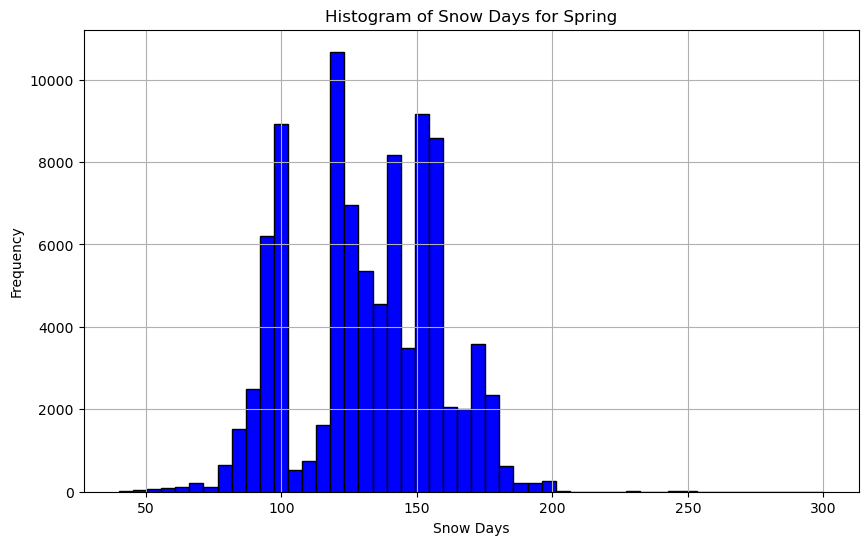

In [2]:
import matplotlib.pyplot as plt
# Flatten the array and remove NaN values
flattened_data = spring.values.flatten()
flattened_data = flattened_data[~np.isnan(flattened_data)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Snow Days for Spring')
plt.xlabel('Snow Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [3]:
import rioxarray
import numpy as np

fall = rioxarray.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/229_237_3266_fall_snow.tif')
# Make 0 values NaN
fall = fall.where(fall != 0, np.nan)

# Print the min and max values
fall_min_value = fall.min().item()
fall_max_value = fall.max().item()

print(f"Min value: {fall_min_value}")
print(f"Max value: {fall_max_value}")

Min value: 143.0
Max value: 306.0


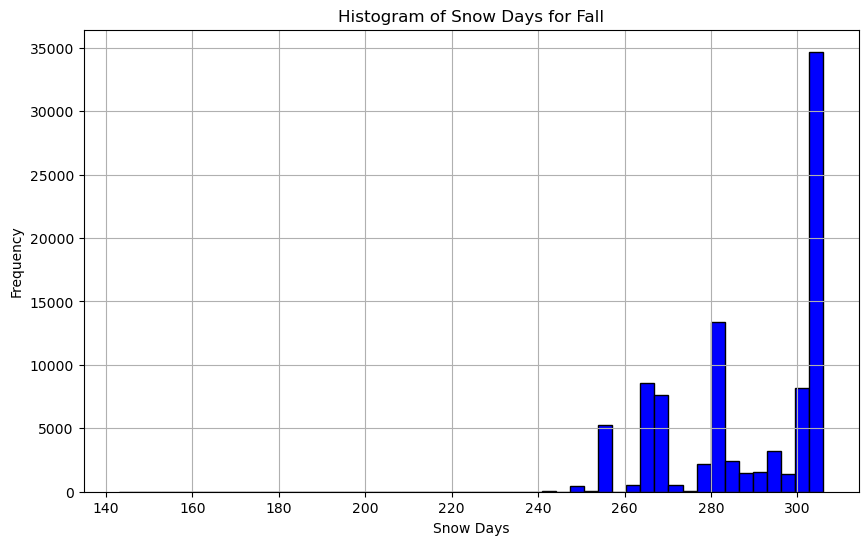

In [4]:
import matplotlib.pyplot as plt
# Flatten the array and remove NaN values
flattened_data = fall.values.flatten()
flattened_data = flattened_data[~np.isnan(flattened_data)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Snow Days for Fall')
plt.xlabel('Snow Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [37]:
import rioxarray as rxr
import numpy as np

# Load the spring and fall snow data
spring = rxr.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/229_237_3266_spring_snow.tif')
fall = rxr.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/229_237_3266_fall_snow.tif')

# Make 0 values NaN for both spring and fall
spring = spring.where(spring != 0, np.nan)
fall = fall.where(fall != 0, np.nan)

# Identify pixels where fall snow day is earlier than spring snow day
fall_earlier_than_spring = fall < spring

# Apply the mask to keep only the pixels where the condition is true
fall_earlier_than_spring_masked = fall.where(fall_earlier_than_spring, np.nan)

# Count the number of problematic pixels
problematic_pixel_count = np.count_nonzero(~np.isnan(fall_earlier_than_spring_masked))

print(f"Number of pixels where fall snow day is earlier than spring snow day: {problematic_pixel_count}")

# Save the result as a new TIFF file
output_file_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/fall_earlier_than_spring_snow_3266.tif'
fall_earlier_than_spring_masked.rio.to_raster(output_file_path)

print(f"File saved to {output_file_path}")


Number of pixels where fall snow day is earlier than spring snow day: 41
File saved to /explore/nobackup/people/spotter5/cnn_mapping/Russia/fall_earlier_than_spring_snow_3266.tif


In [42]:
import rioxarray as rxr
import numpy as np

# Load the spring and fall snow data
spring = rxr.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/217_236_3266_spring_snow_t2.tif')
fall = rxr.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/217_236_3266_fall_snow_t2.tif')

# Make 0 values NaN for both spring and fall
spring = spring.where(spring != 0, np.nan)
fall = fall.where(fall != 0, np.nan)

# Identify pixels where fall snow day is earlier than spring snow day
fall_earlier_than_spring = fall < spring

# Apply the mask to keep only the pixels where the condition is true
fall_earlier_than_spring_masked = fall.where(fall_earlier_than_spring, np.nan)

# Count the number of problematic pixels
problematic_pixel_count = np.count_nonzero(~np.isnan(fall_earlier_than_spring_masked))

print(f"Number of pixels where fall snow day is earlier than spring snow day: {problematic_pixel_count}")

# Save the result as a new TIFF file
output_file_path = '/explore/nobackup/people/spotter5/cnn_mapping/Russia/fall_earlier_than_spring_snow_3266_t2.tif'
fall_earlier_than_spring_masked.rio.to_raster(output_file_path)

print(f"File saved to {output_file_path}")

Number of pixels where fall snow day is earlier than spring snow day: 0
File saved to /explore/nobackup/people/spotter5/cnn_mapping/Russia/fall_earlier_than_spring_snow_3266_t2.tif


Min value: 40.0
Max value: 180.0


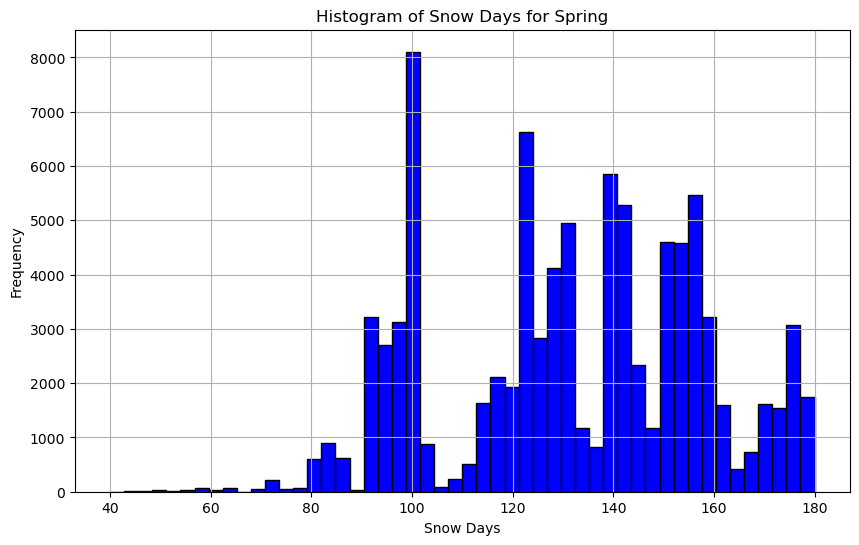

In [7]:
import rioxarray
import numpy as np

fall = rioxarray.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/217_236_3266_spring_snow_t2.tif')
# Make 0 values NaN
fall = fall.where(fall != 0, np.nan)

# Print the min and max values
fall_min_value = fall.min().item()
fall_max_value = fall.max().item()

print(f"Min value: {fall_min_value}")
print(f"Max value: {fall_max_value}")

import matplotlib.pyplot as plt
# Flatten the array and remove NaN values
flattened_data = fall.values.flatten()
flattened_data = flattened_data[~np.isnan(flattened_data)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Snow Days for Spring')
plt.xlabel('Snow Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Min value: 243.0
Max value: 306.0


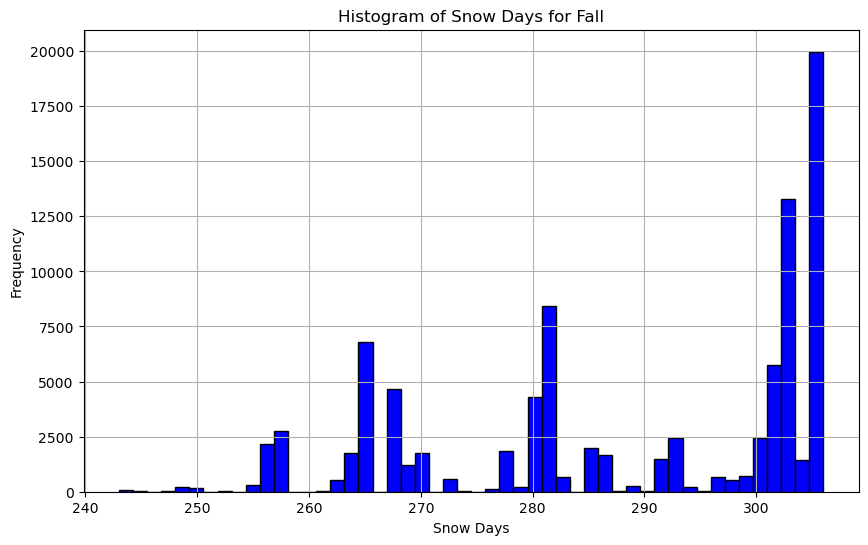

In [8]:
import rioxarray
import numpy as np

fall = rioxarray.open_rasterio('/explore/nobackup/people/spotter5/cnn_mapping/Russia/217_236_3266_fall_snow_t2.tif')
# Make 0 values NaN
fall = fall.where(fall != 0, np.nan)

# Print the min and max values
fall_min_value = fall.min().item()
fall_max_value = fall.max().item()

print(f"Min value: {fall_min_value}")
print(f"Max value: {fall_max_value}")

import matplotlib.pyplot as plt
# Flatten the array and remove NaN values
flattened_data = fall.values.flatten()
flattened_data = flattened_data[~np.isnan(flattened_data)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(flattened_data, bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Snow Days for Fall')
plt.xlabel('Snow Days')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()